In [2]:
import EddyDetectionV2 as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast
from matplotlib.animation import FuncAnimation, FFMpegFileWriter


# Enable/disable computation of different domains ##################
config_parent_domain = False
config_child_domain = False

# Computes full year run eddy detection

time = ['2018-03-01T00:00:00.000000000','2018-06-30T00:00:00.000000000']
####################################################################


# Import data #######################################################################################################################
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(70,75)).sel(X=slice(-22,2))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var_eddies.nc')

df_OW = df['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = df['Eta']

od = ospy.OceanDataset(df)
od = od.compute.horizontal_velocity_magnitude()

df_hor_vel = od['hor_vel']
# Delete no longer used variables which uses memory
del od, df
#####################################################################################################################################
# Child domain
domain_center = [[-20,0],[71,74]]
OW_center = df_OW.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1])).sel(Z=-1)
eta_center = df_eta.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Parent domain
eta = df_eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))
OW = df_OW.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1)).sel(Z=-1)

# Resample data
eta = eta.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
OW = OW.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
hor_vel = df_hor_vel.resample(time='D').mean(dim='time')

# Define time extent
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))
hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))


eta = eta.where(depth > 0, np.nan)
OW = OW.where(depth > 0, np.nan)



Computing magnitude of horizontal velocity


In [3]:
# Computes or loads eddy centerpoints #####################################################################
run = config_child_domain

if run:
    eddyLocation = []
    T = len(eta)
    pbar = tqdm(total=T, desc="Running eddy centerpoint algorythm")
    for i in range(len(eta)):
        eddyLocation.append(eddy.eddyDetection(eta_center[i],OW_center[i]))
        pbar.update(1)
    pbar.close()
    with open("eddyCenterpoints_fullYear.txt",'w') as f:
        for time_ in range(len(eddyLocation)):
            if time_ != len(eddyLocation)-1:
                f.write(str(eddyLocation[time_])+',')
            else:
                f.write(str(eddyLocation[time_]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints_fullYear.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)
############################################################################################################
# Dates to find
dates_to_find = ['2018-03-01T00:00:00.000000000', '2018-06-30T00:00:00.000000000']

# Convert dates to numpy datetime64
dates_to_find = np.array(dates_to_find, dtype='datetime64[ns]')

# Find the index positions
indices = [df_eta.time.where(df_eta.time == date, drop=True).time.values[0] for date in dates_to_find]

# Convert the datetime64 values to integer indices
index_positions = [np.where(df_eta.time.values == date)[0][0] for date in dates_to_find]

print(index_positions)

eddyLocation = eddyLocation[index_positions[0]:index_positions[1]+1]

# Run region detection ##################################################################################
run = config_parent_domain
if run:
    eddies = xr.full_like(eta,fill_value=0)
    eddies = eddies.rename("EddyDetection")
    T = len(eddyLocation)
    pbar = tqdm(total=T, desc="Running algorythm")
    for time in range(len(eddyLocation)):
        eddies[time] = eddy.inner_eddy_region_v5(eddyLocation[time][0],eta=eta[time],warm=True,cold=False,test_calib=False,eddiesData=eddies[time])
        eddies[time] = eddy.inner_eddy_region_v5(eddyLocation[time][1],eta=eta[time],warm=False,cold=True,test_calib=False,eddiesData=eddies[time])
        pbar.update(1)
    # Stream detection#############################################
    cond = (hor_vel >= 0.4) & (eddies == 0)
    eddies = eddies.where(~cond,other=4)
    ###############################################################
    eddies = eddies.where(eddies != 0, np.nan)
    eddies.to_netcdf('/nird/projects/NS9608K/MSc_EK/Data/Eddies_fullYear.nc')
    pbar.close()
else:
    eddies = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Eddies_fullYear.nc')
    eddies = eddies['EddyDetection'].sel(time=slice(time[0],time[1]))
##########################################################################################################
print('### Complete ###')

###Loading previously saved eddy centerpoints###
[181, 302]
### Complete ###


In [4]:
FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(70,75)).sel(X=slice(-22,2)).sel(time=slice(time[0],time[1]))
FWC = FWC.resample(time='D').mean(dim='time')

Generating Frames: 245it [05:08,  1.26s/it]                         


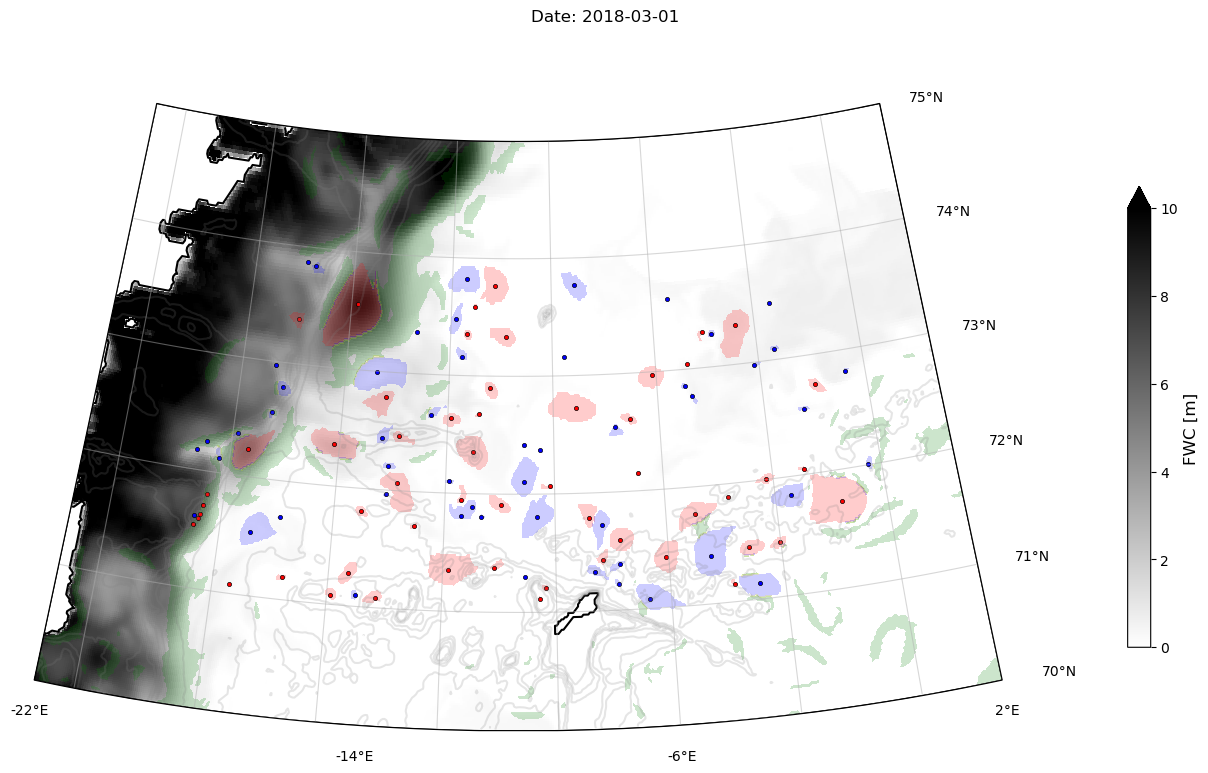

In [5]:
# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22+10, 2+10, 70, 75]

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data using pcolormesh without normalization
pcm1 = axs.pcolormesh(FWC.X,FWC.Y,FWC[0],vmin=0,vmax=10,cmap='binary',transform=ccrs.PlateCarree())
axs.contourf(eddies.X, eddies.Y, eddies[0],levels=bounds, cmap=cmap,norm=norm,alpha=0.2, transform=ccrs.PlateCarree())
for data in eddyLocation[0][0]:
    axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
for data in eddyLocation[0][1]:
    axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
# Add land contour
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs, shrink=0.6, extend='max')
cbar.set_label('FWC [m]', fontsize=12)


# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
axs.add_patch(patch)


# Set the boundary using the transformed path
axs.set_boundary(patch.get_path(), transform=axs.transData)

# Add gridlines without labels
gl = axs.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 8)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')


T = len(eddies.time)
pbar = tqdm(total=T, desc="Generating Frames")

def update_plot(frame):
    axs.clear()
    fig.suptitle(f'Date: {str(eddies.time.values[frame])[0:10]}')
    axs.pcolormesh(FWC.X,FWC.Y,FWC[frame],vmin=0,vmax=10,cmap='binary',transform=ccrs.PlateCarree())
    axs.contourf(eddies.X, eddies.Y, eddies[frame],levels=bounds, cmap=cmap,norm=norm,alpha=0.2, transform=ccrs.PlateCarree())
    for data in eddyLocation[frame][0]:
        axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
    for data in eddyLocation[frame][1]:
        axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
    
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

    
    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
    axs.add_patch(patch)


    # Set the boundary using the transformed path
    axs.set_boundary(patch.get_path(), transform=axs.transData)

    # Add gridlines without labels
    gl = axs.gridlines(draw_labels=False,alpha=0.5)

    # Manually add the labels for the bottom and right sides
    xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 8)  # Adjust the range and step as needed
    yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

    # Add bottom labels
    for xtick in xticks:
        axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='top')

    # Add right labels
    for ytick in yticks:
        axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                fontsize=10, ha='left', va='center')


    pbar.update(1)

ani = FuncAnimation(fig, update_plot, frames=T, interval=400)
ani.save(r'/nird/home/ekv036/MSc/Animations/Eddies_v3_FWC.gif', writer='pillow', progress_callback=lambda i, n: pbar.update(1))
pbar.close()

Generating Frames: 245it [04:42,  1.15s/it]                         


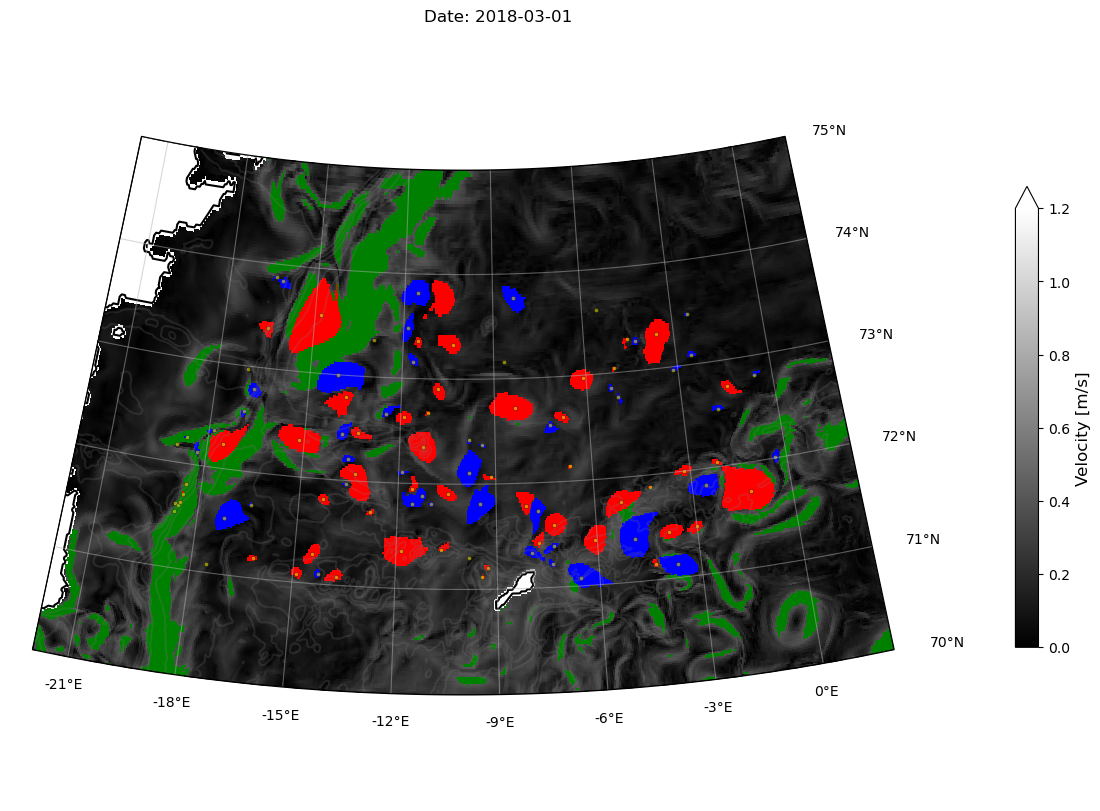

In [6]:
# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22+10, 2+10, 70, 75]

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data using pcolormesh without normalization
pcm1 = axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[0],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
axs.pcolormesh(eddies.X, eddies.Y, eddies[0], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())

for data in zip(eddyLocation[0][0],eddyLocation[0][1]):
    axs.scatter(data[0][1],data[0][0],s=9,edgecolors='black',c='yellow',alpha=0.5,linewidths=0.5,transform=ccrs.PlateCarree())
    axs.scatter(data[1][1],data[1][0],s=9,edgecolors='black',c='yellow',alpha=0.5,linewidths=0.5,transform=ccrs.PlateCarree())
    
# Add land contour
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs, shrink=0.6, extend='max')
cbar.set_label('Velocity [m/s]', fontsize=12)


# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
axs.add_patch(patch)


# Set the boundary using the transformed path
axs.set_boundary(patch.get_path(), transform=axs.transData)

# Add gridlines without labels
gl = axs.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(-21, 0+1, 3)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')


T = len(eddies.time)
pbar = tqdm(total=T, desc="Generating Frames")

def update_plot(frame):
    axs.clear()
    fig.suptitle(f'Date: {str(eddies.time.values[frame])[0:10]}')
    axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[frame],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
    axs.pcolormesh(eddies.X, eddies.Y, eddies[frame], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
    for data in zip(eddyLocation[frame][0],eddyLocation[frame][1]):
        axs.scatter(data[0][1],data[0][0],s=9,edgecolors='black',c='yellow',alpha=0.5,linewidths=0.5,transform=ccrs.PlateCarree())
        axs.scatter(data[1][1],data[1][0],s=9,edgecolors='black',c='yellow',alpha=0.5,linewidths=0.5,transform=ccrs.PlateCarree())
    
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

    
    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
    axs.add_patch(patch)


    # Set the boundary using the transformed path
    axs.set_boundary(patch.get_path(), transform=axs.transData)

    # Add gridlines without labels
    gl = axs.gridlines(draw_labels=False,alpha=0.5)

    # Manually add the labels for the bottom and right sides
    xticks = np.arange(-21, 0+1, 3)  # Adjust the range and step as needed
    yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

    # Add bottom labels
    for xtick in xticks:
        axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='top')

    # Add right labels
    for ytick in yticks:
        axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                fontsize=10, ha='left', va='center')


    pbar.update(1)

ani = FuncAnimation(fig, update_plot, frames=T, interval=400)
ani.save(r'/nird/home/ekv036/MSc/Animations/Eddies_v3.gif', writer='pillow', progress_callback=lambda i, n: pbar.update(1))
pbar.close()